# Project: Study of Electrodes' Ability, Attached to Tissue to Distinct Nonlinear Behaviour of the Cell

> Course: Bioelectrical Phenomena

> Supervisor: Dr. Mehrdad Saviz

> Teaching Assistant: Eng. Tabibi 

> Authors: Mahya Ahandoust 40033010- Mahtab Dastranj 40033024

> Date: January 2025

## A. Problem

In this problem, we want to investigate the ability to detect non-linear behavior of a cell through electrodes attached to the tissue.
Our main method is to calculate the second and third harmonics of the current generated by the membrane and calculate the voltage value that can be recorded by the electrode due to this current activity on the membrane. To solve the problem accurately, a programmer will be needed. But check the approximate numbers obtained with manual calculations to prevent errors.

### 1. Cell Geometry:
Consider the cell as spherical with a diameter of 10 micrometers, approximated by a cube with the same dimensions. Assume that the cell contains Cav2.1-type channels.


### 2. Electrode Configuration:
Assume this cell is located within a tissue environment and connected via two electrodes positioned 1 cm apart. An electric field with an amplitude of E=500V/m and a frequency of f=5Hz is applied. These electrodes are also used to record the electrical activity induced in the cell.

### 3. Membrane Potential and Ionic Currents:
Compute the induced voltage on the membrane, assuming the membrane has low conductivity. Next, calculate the ionic currents through the ion channels. Use the existing model in Channelpedia to determine the conductivity of the channels and assume reasonable values for all quantities, such as the number of channels per unit membrane area, medium conductivity, resting potential, etc., based on the course material.

### 4. Dipole Representation:
Consider a small piece of the membrane as a dipole with a known current. Calculate the voltage recorded by the electrodes from this dipole.

### 5. Harmonics of Recorded Voltage:
Determine the second and third harmonics of the recorded voltage.

### 6. Detectability of Electrical Activity:
If the harmonics are at least 
10μV, they are considered detectable by the digital recording system. Analyze the conditions under which this is possible using the following parameters:
a. Applied field intensity.
b. Number of cells in the same area with similar properties.

### Simplifications:

- For ease of analysis, investigate whether the channel behavior can be approximated under low-frequency conditions.

- Assume that sustained cell stimulation does not result in changes to concentrations or equilibrium voltage within the cell.

## B. Manual Calculations

**Parameters**

- Membrane capacitance: $C_m = 10pF$
- Single channel conductance:$g_{single} = 20pS$
- Channel density: $Density = 1 channel/μm^2$
- Total channels: $N_{channels} = Density.Surface~area = 600$
- Total conductance: $g_{max} = N_{channels} . g_{single} = 12 nS$
- Reversal potential(Calcium): $E_{ca} = 135 mV$
- Capacitance for small cell: $C_m = 10 pF$
- Pulse frequency: $f = 5.0 Hz$
- Period : $1.0 / pulse_frequency = 0.2s$
- Pulse Width = $0.1s$
- Electric field amplitude: $E = 500.0 V/m$
- Membrane voltage: $V_m = -70V$

**Cell Geometric**

$$V_{cell} = (length)^3 = (10\times10^{-6})^3$$
$$Surface~area = 6\times(10\times10^{-6})^2$$
$$C_m = \frac{\epsilon_0 \epsilon_r A}{d}$$


**Ionic Current**

The ionic current for Cav2.1 channels is:
$$I_{ca} = g_{max}\cdot m(t)\cdot(V-E_{ca})$$
$For m at steady state:$
\begin{align*}
m_{\infty} &= \frac{\alpha_m}{\alpha_m + \beta_m} \\
\text{Where:} \\
\alpha_m(V) &= \frac{8.5}{1 + e^{(V-8)/-12.5}}, \quad \beta_m(V) = \frac{35}{1 + e^{(V+74)/14.5}} \\
\text{Substitute } V &= -70 \, \text{mV}: \\
\alpha_m(-70) &= \frac{8.5}{1 + e^{-70-8)/-12.5}} = \frac{8.5}{1 + e^{-78/12.5}} \approx \frac{8.5}{1 + 0.00046} \approx 8.5 \\
\beta_m(-70) &= \frac{35}{1 + e^{(-70+74)/14.5}} = \frac{35}{1 + e^{4/14.5}} \approx \frac{35}{1 + 1.32} \approx 15.1 \\
m_{\infty} &= \frac{\alpha_m}{\alpha_m + \beta_m} = \frac{8.5}{8.5 + 15.1} \approx 0.36
\end{align*}
$$I_{ca} = (1.2\times10^{-8})\times0.36\times((-0.07) - 0.135) = -0.886nA$$
$$\frac{dm}{dt} = \alpha_m(V)(1-m)- \beta_m(V)m$$
$$C_m \frac{dV}{dt} = -I_{ionic} + I_p$$
$$\frac{dV}{dt} = \frac{-I_{ionic} + I_p}{C_m}$$

**Dipole Potential**
$$p(t) = I_{ionic} \cdot dipole~length$$
$$V_{dipole} = \frac{p(t)}{4\pi\epsilon_0r^2}$$

## C. Code

In [10]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt

### C.a Parameters

In [11]:
l_cell = 10e-6
A = 6 * (l_cell**2)
volume = l_cell**3
e_r = 3
e0 =8.85e-12
d = 1e-9
Cm = e0 * e_r * A / d
single_channel_conductance = 20e-12
channel_density = 10
num_channels = channel_density * (A * 1e12)  # area in µm^2
g_max = num_channels * single_channel_conductance
dipole_length = 1e-6
v_rev = 135.0  # mV
r_e = 1e12
r = 0.01 # distance from electrode
initial_voltage = -70
# Pulsed external field parameters
pulse_frequency = 5.0  # Hz
pulse_period = 1.0 / pulse_frequency
pulse_width = 0.1  # seconds
field_amplitude = 500.0  # V/m
scale_factor = 5e3 # to normalize the dipole voltage (V_dipole) for better visualization

# Simulation parameters
simulation_time = 2.0  # seconds
time_step = 1e-5
simulation_time_array = np.arange(0, simulation_time, time_step)

### C.b Functions

In [12]:
def pulse_wave(time, period, width): return 1 if (time % period < width) else 0

def alpha_m(voltage): return 8.5 / (1.0 + np.exp((voltage - 8.0) / -12.5))

def beta_m(voltage): return 35.0 / (1.0 + np.exp((voltage + 74.0) / 14.5))

def dynamics(time, variables):
    voltage, gating_variable = variables

    # Gating variable ODE
    alpha = alpha_m(voltage)
    beta = beta_m(voltage)
    gating_derivative = alpha * (1 - gating_variable) - beta * gating_variable

    # Ionic current
    ionic_current = g_max * gating_variable * ((voltage - v_rev) * 1e-3)

    # External field
    E = field_amplitude * pulse_wave(time, pulse_period, pulse_width)
    i_p = (E * l_cell / r_e) * pulse_wave(time, pulse_period, pulse_width)

    # Membrane potential derivative
    dVm_dt = (-ionic_current + i_p) / Cm
    return [dVm_dt * 1e3, gating_derivative]


initial_gating = alpha_m(initial_voltage) / (alpha_m(initial_voltage) + beta_m(initial_voltage))
initial_conditions = [initial_voltage, initial_gating]

solution = solve_ivp(dynamics, [0, simulation_time], initial_conditions, t_eval=simulation_time_array, method="RK45")
# The solve_ivp function numerically integrates an ODE system over a specified time interval. It uses various methods to approximate the solution based on the provided inputs.


def p(I, d): return I * d

### C.c Induced voltage on the membrane

In [13]:
time_solution = solution.t
voltage_solution = solution.y[0]
gating_solution = solution.y[1]

E_array = np.array([field_amplitude * pulse_wave(t, pulse_period, pulse_width) for t in time_solution])
ip_array = E_array * l_cell / r_e
ionic_current_array = g_max * gating_solution * ((voltage_solution - v_rev) * 1e-3)

### C.d Dipole

In [24]:
Vdi_array = p(np.abs(ionic_current_array), dipole_length)/ (4 * np.pi * r**2)

# Extract the relevant portion of the voltage solution (ignoring transients)
signal_start_time = 1.0  # Ignore the first second to skip transients
start_index = np.where(time_solution >= signal_start_time)[0][0]
voltage_signal = Vdi_array[start_index:]
time_signal = time_solution[start_index:]

# Compute the Fourier Transform of the voltage signal
dt = time_signal[1] - time_signal[0]  # Time step
voltage_fft = fft(voltage_signal/scale_factor)
frequencies = fftfreq(len(voltage_signal), dt)

# Extract the fundamental frequency and harmonics
fundamental_frequency = 1.0 / pulse_period  # Fundamental frequency
second_harmonic = 2 * fundamental_frequency
third_harmonic = 3 * fundamental_frequency

# Find indices for the second and third harmonics
second_harmonic_index = np.argmin(np.abs(frequencies - second_harmonic))
third_harmonic_index = np.argmin(np.abs(frequencies - third_harmonic))

# Get the amplitudes at the second and third harmonics
second_harmonic_amplitude = np.abs(voltage_fft[second_harmonic_index])
third_harmonic_amplitude = np.abs(voltage_fft[third_harmonic_index])

# Output the results
print(f"Second harmonic ({second_harmonic:.2f} Hz) amplitude: {second_harmonic_amplitude:.3e}")
print(f"Third harmonic ({third_harmonic:.2f} Hz) amplitude: {third_harmonic_amplitude:.3e}")

Second harmonic (10.00 Hz) amplitude: 8.451e-18
Third harmonic (15.00 Hz) amplitude: 8.420e-18


### C.e Visualization

C:\Users\MDastranj\AppData\Local\Temp\ipykernel_3900\1634587828.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


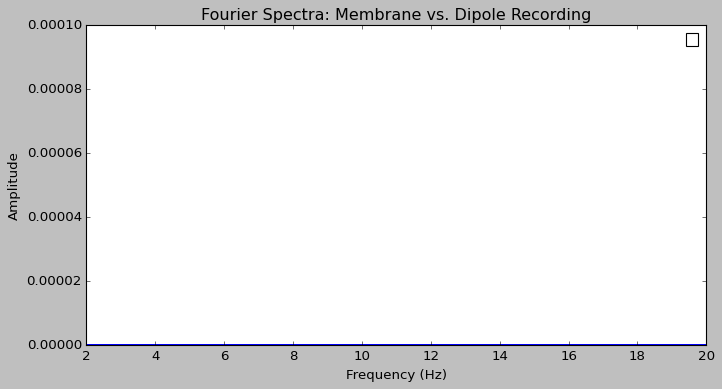

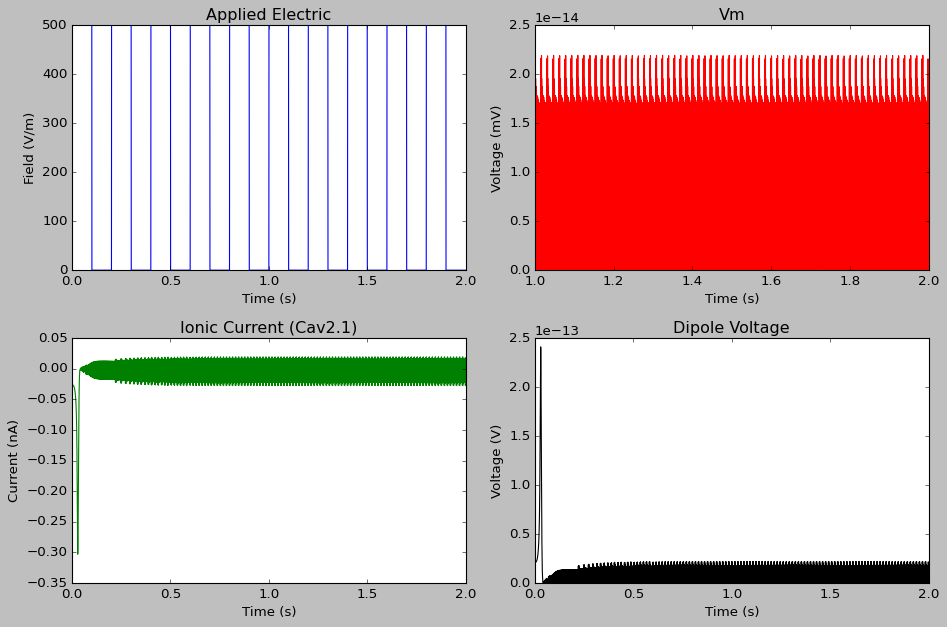

In [31]:
plt.figure(figsize=(10, 5))
plt.plot(frequencies, np.abs(voltage_fft))
plt.xlim(2, 20)  # adjust as needed
plt.ylim(0, 0.0001)  # adjust as needed
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Fourier Spectra: Membrane vs. Dipole Recording")
plt.legend()
plt.show()
# Slice time_solution to match voltage_signal
time_signal = time_solution[start_index:]  # Ensure the time array matches the sliced data

# Plotting the results
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Panel 1: Applied Electric Field
axes[0, 0].plot(time_solution, E_array, 'b-')
axes[0, 0].set_title("Applied Electric")
axes[0, 0].set_xlabel("Time (s)")
axes[0, 0].set_ylabel("Field (V/m)")

# Panel 2: Transmembrane Voltage
axes[0, 1].plot(time_signal, voltage_signal, 'r-')  # Use sliced time_signal
axes[0, 1].set_title("Vm")
axes[0, 1].set_xlabel("Time (s)")
axes[0, 1].set_ylabel("Voltage (mV)")

# Panel 3: Ionic Current
axes[1, 0].plot(time_solution, ionic_current_array * 1e9, 'g-')  # Current in nA
axes[1, 0].set_title("Ionic Current (Cav2.1)")
axes[1, 0].set_xlabel("Time (s)")
axes[1, 0].set_ylabel("Current (nA)")

# Panel 4: Dipole Voltage
axes[1, 1].plot(time_solution, Vdi_array, 'k-')
axes[1, 1].set_title("Dipole Voltage")
axes[1, 1].set_xlabel("Time (s)")
axes[1, 1].set_ylabel("Voltage (V)")

plt.tight_layout()
plt.show()


Yes, the behavior of a cell under small, low-frequency stimulation can often be approximated effectively. This is particularly useful for simplifying the analysis of complex systems like ion channels and membrane dynamics. Here's an overview of why and how:

---

### **Why Approximate Behavior for Small, Low-Frequency Stimulation?**

1. **Linearity Assumption:**
   - At low frequencies, the response of the cell (voltage, current) to external stimuli tends to be linear because:
     - Nonlinear effects (e.g., channel saturation, voltage-dependent gating) are less pronounced.
     - Time-dependent changes in ionic concentrations or gating variables are slow and approximate a quasi-steady-state.

2. **Dominance of Fundamental Frequency:**
   - For low-frequency stimulation, the higher harmonics generated by nonlinearities are weaker, making the response predominantly determined by the fundamental frequency.

3. **Small Signal Analysis:**
   - For small amplitudes, the nonlinear terms in the governing equations (e.g., gating kinetics or ionic current equations) can often be linearized using Taylor expansions. This drastically simplifies calculations.

---

### **How to Approximate Behavior?**

1. **Linearization:**
   - Linearize the gating kinetics and ionic current equations around the resting potential (\( V_\text{rest} \)) and steady-state gating variable $(\( m_\infty(V_\text{rest}) \)):
     \[
     m(t) \approx m_\infty(V_\text{rest}) + \Delta m(t)
     \]
     \[
     \Delta m(t) \approx \frac{dm}{dV}\big|_{V_\text{rest}} \cdot \Delta V(t)
     \]$
   - The resulting system of equations becomes linear, allowing the use of standard techniques for solving ODEs.

2. **Frequency Domain Analysis:**
   - For sinusoidal low-frequency input $\( E(t) = E_0 \sin(2 \pi f t) \)$, the response can be analyzed using Fourier methods, focusing on the fundamental frequency $\( f \)$:
     $\[
     V(t) \approx V_\text{rest} + A \sin(2 \pi f t + \phi)
     \]$
     where $\( A \)$ is the amplitude of the voltage response and $\( \phi \)$ is the phase shift.

3. **Neglect Nonlinear Terms:**
   - At low frequencies, higher-order terms (e.g., $\( m^2, V^2 \))$ in the equations contribute minimally to the response and can often be ignored.

4. **Steady-State Approximations:**
   - Assume that gating variables quickly reach their steady-state values relative to the timescale of the low-frequency input. For example:
     $\[
     m(t) \approx m_\infty(V(t))
     \]$

---

### **Limitations of the Approximation**

1. **Nonlinearity at Higher Amplitudes:**
   - If the input amplitude is not small, the gating variables may exhibit nonlinear behavior even at low frequencies, invalidating the linear approximation.

2. **Higher Harmonics:**
   - While these are typically negligible at low frequencies, small contributions to higher harmonics still exist, especially in voltage-sensitive systems.

3. **Frequency-Dependent Effects:**
   - At very low frequencies, time-dependent changes in ion concentrations or membrane properties (e.g., slow inactivation) may become significant, complicating the approximation.

---

### **Practical Application in the Given Problem**
- **Low-Frequency Input:**
  - At $\( f = 5 \, \text{Hz} \)$, the approximation is valid for small input amplitudes like $\( E = 500 \, \text{V/m} \)$.
  
- **Expected Behavior:**
  - The transmembrane voltage response will predominantly follow the external field, with minimal contributions from higher harmonics.
  - The ionic currents and dipole voltage can be approximated using the fundamental frequency response.

- **Simplification:**
  - Linearize the equations for $\( V \)$ and $\( m \)$, neglect nonlinear terms, and focus on the steady-state and fundamental frequency contributions.

---

### **Conclusion**
For small, low-frequency inputs, the behavior of the cell can be approximated using linearized equations and steady-state assumptions. This simplifies the analysis and highlights the fundamental frequency response while neglecting higher-order effects. However, care must be taken if input amplitudes increase or if the system is driven at higher frequencies.